# Data Loading

In [54]:
import pandas as pd
import os
from tqdm import tqdm
from joblib import dump, load
import json
import textwrap

# Load dataset from Kaggle

In [55]:
KAGGLE_JSON_PATH = os.path.expanduser("~/Downloads/kaggle.json")
DATASET_NAME = 'Cornell-University/arxiv'
ZIP_FILE = 'arxiv.zip'
DATA_FILE = 'arxiv-metadata-oai-snapshot.json'
DATA_DIR = 'data'
FULL_FILE_PATH = os.path.join(DATA_DIR, DATA_FILE)
MODEL_DIR = 'models'

In [56]:
os.makedirs(MODEL_DIR, exist_ok=True)

In [57]:
if os.path.exists(FULL_FILE_PATH):
    print("File already exists. Skipping download.")
else:
    print("File not found. Downloading...")
    try:
        !pip install -q kaggle
        !mkdir -p {DATA_DIR}
        !mkdir -p ~/.kaggle
        !cp {KAGGLE_JSON_PATH} ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        # Download the arXiv dataset
        !kaggle datasets download -d {DATASET_NAME}
        # Unzip it
        !unzip -o {ZIP_FILE}
        !rm {ZIP_FILE}
        !mv {DATA_FILE} {FULL_FILE_PATH}
        print(f"Dataset successfully downloaded and moved to {FULL_FILE_PATH}")
    except Exception as e:
        print(f"An error occurred while downloading the dataset: {e}")
        raise

File already exists. Skipping download.


# Create data frame

In [62]:
# Load the arXiv metadata
data = []
with open(FULL_FILE_PATH, 'r') as f:
    for line in tqdm(f, desc="Loading data"):
        data.append(json.loads(line))
        if len(data) >= 50000:  # Start with 50k papers for faster experimentation
            break

Loading data: 49999it [00:02, 19473.93it/s]


In [59]:
df = pd.DataFrame(data)
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


# Data Exploration

In [60]:
print("Shape: ", df.shape)
print("Columns: ", df.columns.tolist())

print("\nSample: ")
sample = df.iloc[0]

for key, value in sample.items():
    print(f"{key}: {value}")

Shape:  (110000, 14)
Columns:  ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']

Sample: 
id: 0704.0001
submitter: Pavel Nadolsky
authors: C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments: 37 pages, 15 figures; published version
journal-ref: Phys.Rev.D76:013009,2007
doi: 10.1103/PhysRevD.76.013009
report-no: ANL-HEP-PR-07-12
categories: hep-ph
license: None
abstract:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic a

# Data Preprocessing

In [61]:
print(f"Before cleaning: {len(df)} papers")

df_clean = df[
    df["abstract"].notna() &
    df["title"].notna() &
    (df["abstract"].str.strip() != "") &
    (df["title"].str.strip() != "")
].copy()

print(f"After cleaning: {len(df_clean)} papers")
print(f"Removed {len(df) - len(df_clean)} papers")

df_clean["text"] = df_clean["title"] + " " + df_clean["abstract"]

print("\nText Statistics: ")
print(f"Average length: {df_clean['text'].str.len().mean()}")
print(f"Median length: {df_clean['text'].str.len().median()}")
print(f"Minimum length: {df_clean['text'].str.len().min()}")
print(f"Maximum length: {df_clean['text'].str.len().max()}")

Before cleaning: 110000 papers
After cleaning: 110000 papers
Removed 0 papers

Text Statistics: 
Average length: 872.2997
Median length: 800.0
Minimum length: 56
Maximum length: 2897


In [10]:
print("\nCategory statistics: ")

df_clean["primary_category"] = df_clean["categories"].str.split().str[0]

print("Total number of categories: ", df_clean["primary_category"].nunique())
print("Top 10 categories: ", df_clean["primary_category"].value_counts().head(10))


Category statistics: 
Total number of categories:  133
Top 10 categories:  primary_category
astro-ph              9208
hep-ph                3591
hep-th                3020
quant-ph              2646
gr-qc                 1670
cond-mat.mtrl-sci     1526
cond-mat.mes-hall     1506
cond-mat.str-el       1345
cond-mat.stat-mech    1232
math-ph               1047
Name: count, dtype: int64


## Baseline 1 - Term Frequency-Inverse Document Frequency (TF-IDF)

## 1. Term Frequency (TF)
How often a term appears in a document.

$$TF(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}$$

**Example:** If "machine" appears 5 times in a 100-word document:
- TF("machine") = 5/100 = 0.05

## 2. Inverse Document Frequency (IDF)
How rare or common a term is across all documents.

$$IDF(t) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents containing term } t}\right)$$

**Example:** If "machine" appears in 1,000 out of 10,000 documents:
- IDF("machine") = log(10,000/1,000) = log(10) = 2.30

## 3. TF-IDF Score
The product of TF and IDF.

$$\text{TF-IDF}(t, d) = TF(t, d) \times IDF(t)$$

**Example:** 
- TF-IDF("machine") = 0.05 × 2.30 = 0.115

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import os

TF_IDF_PATH=os.path.join(MODEL_DIR, 'tf_idf')
os.makedirs(TF_IDF_PATH, exist_ok=True)

TFIDF_VECTORIZER_PATH=os.path.join(TF_IDF_PATH, 'tfidf_vectorizer.joblib')
TFIDF_MATRIX_PATH=os.path.join(TF_IDF_PATH, 'tfidf_matrix.joblib')

if os.path.exists(TFIDF_VECTORIZER_PATH) and os.path.exists(TFIDF_MATRIX_PATH):
    print("Loading existing TF-IDF vectorizer and matrix...")
    vectorizer = load(TFIDF_VECTORIZER_PATH)
    tfidf_matrix = load(TFIDF_MATRIX_PATH)
else:
    print("Fitting TF-IDF vectorizer...")
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=5000,      # Keep top 5000 most important words
        stop_words='english',   # Remove common words like "the", "is", "and"
        ngram_range=(1, 2),     # Use single words and 2-word phrases
        min_df=2,               # Word must appear in at least 2 documents
        max_df=0.8              # Ignore words that appear in >80% of documents
    )
    tfidf_matrix = vectorizer.fit_transform(df_clean['text'])
    print("Saving TF-IDF vectorizer and matrix...")
    dump(vectorizer, TFIDF_VECTORIZER_PATH)
    dump(tfidf_matrix, TFIDF_MATRIX_PATH)

print(f"\nTF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"(rows=papers, columns=vocabulary size)")
print(f"\nMatrix sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

Loading existing TF-IDF vectorizer and matrix...

TF-IDF Matrix Shape: (50000, 5000)
(rows=papers, columns=vocabulary size)

Matrix sparsity: 99.02%


In [12]:
feature_names = vectorizer.get_feature_names_out()
print("Total vocabulary size: ", len(feature_names))
print("First 30 terms: ", feature_names[:30])
print("Last 30 terms: ", feature_names[-30:])

import random

random.seed(42)
random_indices = random.sample(range(len(feature_names)), 30)
print("Random 30 terms: ", [feature_names[i] for i in sorted(random_indices)])

Total vocabulary size:  5000
First 30 terms:  ['000' '001' '01' '02' '03' '04' '05' '06' '07' '08' '10' '10 10' '10 11'
 '10 12' '10 15' '10 kev' '100' '1000' '11' '110' '111' '12' '120' '13'
 '14' '15' '150' '16' '17' '18']
Last 30 terms:  ['x_n' 'xi' 'xmm' 'xmm newton' 'xy' 'yang' 'yang mills' 'yau' 'year'
 'years' 'yield' 'yielding' 'yields' 'young' 'young stars' 'young stellar'
 'yr' 'yukawa' 'z_' 'z_2' 'zeeman' 'zero' 'zero temperature' 'zeros'
 'zeta' 'zeta function' 'zigzag' 'zn' 'zone' 'zones']
Random 30 terms:  ['29', 'advances', 'agent', 'algorithms', 'amorphous', 'characterizing', 'closely related', 'compactification', 'confidence', 'database', 'diffusive', 'exact solution', 'films', 'fine structure', 'flat', 'friction', 'ghz', 'illustrated', 'improvements', 'points', 'posed', 'possess', 'quantum states', 'shorter', 'sudden', 'sufficient conditions', 'tev', 'valued', 'variables', 'weights']


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def get_tfidf_recommendations(paper_idx, top_k=10):
  """
  Get top-k most similar papers using TF-IDF and Cosine similarity.
  """
  query_vector = tfidf_matrix[paper_idx]
  similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
  similar_indices = similarities.argsort()[-top_k-1:-1][::-1]
  results = df_clean.iloc[similar_indices][["id", "title", "primary_category"]].copy()
  results["similarity_score"] = similarities[similar_indices]
  return results

In [14]:
# Test it on the first paper
print("Query paper: ")
print("id: ", df_clean.iloc[0]["id"])
print("title: ", df_clean.iloc[0]["title"])
print("primary_category: ", df_clean.iloc[0]["primary_category"])
print("abstract: ", df_clean.iloc[0]["abstract"])

print("\nTop 10 recommendations: ")
recommendations = get_tfidf_recommendations(0, 10)

for idx, row in recommendations.iterrows():
  print(f"id: {row['id']}")
  print(f"title: {row['title']}")
  print(f"primary_category: {row['primary_category']}")
  print(f"similarity_score: {row['similarity_score']}")
  print("\n")

Query paper: 
id:  0704.0001
title:  Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
primary_category:  hep-ph
abstract:    A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with t

# Baseline 2 - SentenceTransformer

In [15]:
from sentence_transformers import SentenceTransformer
import os

os.makedirs(os.path.join(MODEL_DIR, "sentence_transformer"), exist_ok=True)

EMBEDDINGS_PATH = os.path.join(MODEL_DIR, "sentence_transformer", "embeddings.npy")

# Check if embeddings already exist
if os.path.exists(EMBEDDINGS_PATH):
    print("Loading existing embeddings...")
    sentence_embeddings = np.load(EMBEDDINGS_PATH)
    print(f"Loaded embeddings: {sentence_embeddings.shape}")

else:
    print("No existing embeddings found. Generating new ones...")

    # Load model
    st_model = SentenceTransformer('all-MiniLM-L6-v2')
    print("Model loaded: all-MiniLM-L6-v2")

    # Generate embeddings
    print("\nGenerating embeddings")

    sentence_embeddings = st_model.encode(
        df_clean['text'].tolist(),
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True
    )

    print(f"Embeddings generated: {sentence_embeddings.shape}")

    # Save for next time
    np.save(EMBEDDINGS_PATH, sentence_embeddings)
    print(f"Embeddings saved to {EMBEDDINGS_PATH}")

Loading existing embeddings...
Loaded embeddings: (50000, 384)


In [16]:
def get_st_recommendations(embeddings, paper_idx, top_k=10):
  """Get top k recommendations using sentence transformer embeddings and cosine similarity"""
  query_embedding = embeddings[paper_idx]
  similarities = cosine_similarity([query_embedding], embeddings)[0]
  top_indices = similarities.argsort()[-top_k-1:-1][::-1]
  return top_indices, similarities[top_indices]

In [17]:
# Test it on the first paper
print("Query paper: ")
print("id: ", df_clean.iloc[0]["id"])
print("title: ", df_clean.iloc[0]["title"])
print("primary_category: ", df_clean.iloc[0]["primary_category"])
print("abstract: ", df_clean.iloc[0]["abstract"])

print("\nTop 10 recommendations: ")
rec_indices, rec_scores = get_st_recommendations(sentence_embeddings, 0, 10)

for rank, (idx, score) in enumerate(zip(rec_indices, rec_scores), 1):
  row = df_clean.iloc[idx]
  print(f"id: {row['id']}")
  print(f"title: {row['title']}")
  print(f"primary_category: {row['primary_category']}")
  print(f"similarity_score: {score}")
  print("\n")

Query paper: 
id:  0704.0001
title:  Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
primary_category:  hep-ph
abstract:    A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with t

In [18]:
# Unified model

class RecommendationModel:
    """Base class for all recommendation models"""
    def __init__(self, name):
        self.name = name
    
    def get_recommendations(self, query_vector, top_k=10):
        """Get top-k recommendations for a given query vector"""
        raise NotImplementedError
        
    def get_recommendations_for_paper(self, paper_idx, top_k=10):
        """Get top-k recommendations for a given paper"""
        raise NotImplementedError
    
    def get_recommendations_for_text(self, query_text, top_k=10):
        """Get top-k recommendations for a query text"""
        raise NotImplementedError

class TFIDFModel(RecommendationModel):
    def __init__(self):
        super().__init__("TF-IDF")
        if os.path.exists(TFIDF_VECTORIZER_PATH) and os.path.exists(TFIDF_MATRIX_PATH):
            print("Loading existing TF-IDF model...")
            self.vectorizer = load(TFIDF_VECTORIZER_PATH)
            self.tfidf_matrix = load(TFIDF_MATRIX_PATH)
        else:
            raise Exception("Model file not found")
    
    def get_recommendations(self, query_vector, top_k=10):
        from sklearn.metrics.pairwise import cosine_similarity
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        top_indices = similarities.argsort()[-top_k-1:-1][::-1]
        results = []
        for rank, idx in enumerate(top_indices, 1):
            results.append({
                'rank': rank,
                'similarity': similarities[idx],
                'paper': df.iloc[idx],
            })
        return pd.DataFrame(results)
    
    def get_recommendations_for_text(self, query_text, top_k=10):
        query_vector = self.vectorizer.transform([query_text])
        return self.get_recommendations(query_vector, top_k)
    
    def get_recommendations_for_paper(self, paper_idx, top_k=10):
        query_vector = self.tfidf_matrix[paper_idx]
        return self.get_recommendations(query_vector, top_k)


class EmbeddingModel(RecommendationModel):
    def __init__(self, name):
        super().__init__(name)
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        if os.path.exists(EMBEDDINGS_PATH):
            print("Loading existing embeddings...")
            self.embeddings = np.load(EMBEDDINGS_PATH)
        else:
            raise Exception("Embeddings file not found")
    
    def get_recommendations(self, query_vector, top_k=10):
        from sklearn.metrics.pairwise import cosine_similarity
        
        similarities = cosine_similarity([query_vector], self.embeddings)[0]
        top_indices = similarities.argsort()[-top_k-1:-1][::-1]
        
        results = []
        for rank, idx in enumerate(top_indices, 1):
            results.append({
                'rank': rank,
                'similarity': similarities[idx],
                'paper': df.iloc[idx],
            })
        return pd.DataFrame(results)
    
    def get_recommendations_for_text(self, query_text, top_k=10):
        query_vector = self.model.encode([query_text], convert_to_numpy=True)[0]
        return self.get_recommendations(query_vector, top_k)
    
    def get_recommendations_for_paper(self, paper_idx, top_k=10):
        query_vector = self.embeddings[paper_idx]
        return self.get_recommendations(query_vector, top_k)

# Initialize your models
models = {
    'tfidf': TFIDFModel(),
    'sentence_transformer': EmbeddingModel('SentenceTransformer'),
    # Later: 'finetuned': EmbeddingModel('FineTuned', finetuned_embeddings)
}

print("Models registered:")
for name, model in models.items():
    print(f"  - {model.name}")

Loading existing TF-IDF model...
Loading existing embeddings...
Models registered:
  - TF-IDF
  - SentenceTransformer


In [19]:
models['sentence_transformer'].get_recommendations_for_paper(0)

,rank,similarity,paper
0,1,0.770095,id ...
1,2,0.757511,id ...
2,3,0.752004,id ...
3,4,0.745720,id ...
4,5,0.739225,id ...
5,6,0.728684,id ...
6,7,0.717010,id ...
7,8,0.711889,id ...
8,9,0.710573,id ...
9,10,0.707560,id ...


# Evaluation

## LLM-Based Recommendation Evaluation Summary

This evaluation procedure measures the quality and effectiveness of different recommendation models by leveraging Large Language Models (LLMs) as **expert human judges**.

---

### 1. Evaluation Procedure Overview


**Sampling:** The process begins by selecting **$N=20$** random papers from the full dataset using `np.random.choice()`. These papers serve as the diverse set of query inputs for the evaluation.

**Recommendation:** For each selected query paper, the model under test is used to generate $K$ recommendations.

**LLM Scoring:** An LLM ensemble (like `gpt-4o`, `gpt-5-mini`) as an expert judge is then used for scoring. The LLMs are prompted with the query and recommendations to assign a **Relevance Score (1-5)** to each recommended paper based on detailed criteria (topic alignment, methodology, etc.).

**Metric Calculation:** The assigned relevance scores are used to compute performance metrics like Precision, MRR, nDCG etc for that specific query.

**Aggregation:** Finally, all individual query results are collected. The results for each model are summarized by reporting the **mean ($\mu$) and standard deviation ($\sigma$)** for every metric across all 20 evaluated samples using a Pandas DataFrame.

---

### 2. Metrics for Model Comparison

All metrics are calculated for the Top $K=10$ recommendations. **Relevance is binarized where Score $\ge 3$ is considered Relevant.**

| Metric | Type | What It Measures | Best For |
| :--- | :--- | :--- | :--- |
| **Precision@K** | Binary | The **fraction of the Top $K$ items that are relevant**. Focuses on the accuracy of the small list. | Quality/Accuracy |
| **Recall@K** | Binary | The **fraction of all available relevant items** found in the Top $K$ list (assuming a maximum of 10 relevant exist). | Coverage |
| **F1@K** | Binary | The **harmonic mean** of Precision and Recall, balancing both measures. | Balanced Performance |
| **MAP@K** | Ranking | The **Average Precision** calculated at every relevant item's position, then averaged across queries. Highly sensitive to the quality of the overall ranking. | Ranking Quality |
| **nDCG@K** | Graded (1-5) | Measures the **graded utility** (satisfaction) of the list, giving higher weight to **higher scores** and **better positions**. | Graded Relevance |
| **MRR** | Ranking | The reciprocal rank of the **first relevant item** found. Measures how quickly the user finds a good result. | First Hit Time |
| **Category Consistency** | Category Match | The proportion of recommended items whose primary category **matches** the query paper's primary category. | Topical Specificity |

In [20]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from collections import defaultdict

class ScoredPaper(BaseModel):
    score: int = Field(
        description="Relevance score (1-5)", 
        ge=1, 
        le=5
    ),
    reasoning: str = Field(
        description="Reasoning for the score"
    )

In [21]:
print(os.getenv("CLAUDE_3_5_HAIKU"))

intplat-claude-3-5-haiku-20241022-v1:0


In [22]:
class Evaluator:
    def __init__(self):
        self.llms = {
            'gpt-4o': ChatOpenAI(
                model=os.getenv("GPT_4O"),
                temperature=0.1,
                openai_api_key=os.getenv("LLM_API_KEY"),
                base_url=os.getenv("LLM_BASE_URL"),
            ).with_structured_output(ScoredPaper),
            'claude-3.5-haiku': ChatOpenAI(
                model=os.getenv("CLAUDE_3_5_HAIKU"),
                openai_api_key=os.getenv("LLM_API_KEY"),
                base_url=os.getenv("LLM_BASE_URL"),
            ).with_structured_output(ScoredPaper),
        }
    
    def get_score_for_recommendation(self, llm, query_paper, recommendation):
        prompt = textwrap.dedent(
            f"""You are an expert research paper recommendation evaluator. Evaluate the relevance of the given recommended paper to the given query paper.
            QUERY PAPER:
                Title: {query_paper['title']}
                Abstract: {query_paper['abstract']}
                Categories: {query_paper['categories']}
            
            RECOMMENDATION TO EVALUATE:
                Title: {recommendation['title']}
                Abstract: {recommendation['abstract']}
                Categories: {recommendation['categories']}
                
            SCORING CRITERIA:
                5 = Highly relevant (same specific topic, methods, or direct extension)
                4 = Relevant (closely related field, similar techniques)  
                3 = Moderately relevant (same broad area, some conceptual overlap)
                2 = Weakly relevant (distant connection, different subfield)
                1 = Not relevant (unrelated topic)
            
            Consider:
                - Topic alignment and research questions
                - Methodological similarity
                - Shared keywords and concepts
                - Potential for citation
                - Same problem domain
            """
        )
        response = llm.invoke(prompt)
        print("LLM Response:", response)
        return response
    
    def get_scores(self, query_paper, recommendations):
        all_scores = defaultdict(dict)
        avg_scores = []
        for rec in recommendations:
            score = 0
            for llm_name, llm in self.llms.items():
                response = self.get_score_for_recommendation(llm, query_paper, rec)
                score += response.score
                all_scores[llm_name][rec['id']] = response
            avg_score = score / len(self.llms)
            avg_scores.append(avg_score)
        
        print("LLM Eval Result:", all_scores)
        print("Average Scores:", avg_scores)
        
        if not all_scores:
            return [3] * len(recommendations)
        else:
            return avg_scores
        

In [23]:
def calculate_metrics(scores, rec_categories, query_category, k=10):
    """Calculate all required metrics"""
    scores = np.array(scores[:k])
    binary = (scores >= 3).astype(int)
    
    # Basic metrics
    precision = np.mean(binary)
    recall = np.sum(binary) / min(10, k)  # Assume 10 relevant exist
    
    metrics = {
        'precision_at_k': precision,
        'recall_at_k': recall,
        'f1_at_k': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0,
        'avg_relevance': np.mean(scores),
        'category_consistency': np.mean([1 if cat == query_category else 0 for cat in rec_categories[:k]])
    }
    
    # MRR
    if np.any(binary):
        metrics['mrr'] = 1.0 / (np.argmax(binary) + 1)
    else:
        metrics['mrr'] = 0.0
    
    # MAP@K
    relevant_positions = np.where(binary)[0]
    if len(relevant_positions) > 0:
        precisions = [(i+1) / (pos+1) for i, pos in enumerate(relevant_positions)]
        metrics['map_at_k'] = np.mean(precisions)
    else:
        metrics['map_at_k'] = 0.0
    
    # nDCG@K
    dcg = np.sum((2**scores - 1) / np.log2(np.arange(1, k+1) + 1))
    ideal = np.sum((2**np.sort(scores)[::-1] - 1) / np.log2(np.arange(1, k+1) + 1))
    metrics['ndcg_at_k'] = dcg / ideal if ideal > 0 else 0.0
    
    return metrics

In [24]:
def evaluate_models(models, df, n_samples=20, top_k=10):
    """Main evaluation function"""
    evaluator = Evaluator()
    eval_indices = np.random.choice(len(df), n_samples, replace=False)
    
    all_results = {}
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        model_results = []
        
        for idx in tqdm(eval_indices):
            # Get recommendations
            recs_df = model.get_recommendations_for_paper(idx, top_k=top_k)
            
            # Prepare data
            query = df.iloc[idx].to_dict()
            recs = [row['paper'].to_dict() for _, row in recs_df.iterrows()]
            rec_categories = [r.get('primary_category', '') for r in recs]
            
            # Get scores from LLMs
            scores = evaluator.get_scores(query, recs)
            
            # Calculate all metrics
            metrics = calculate_metrics(scores, rec_categories, 
                                       query.get('primary_category', ''), k=top_k)
            model_results.append(metrics)
        
        all_results[model_name] = pd.DataFrame(model_results)
    
    # Print summary
    for model_name, results_df in all_results.items():
        print(f"\n{model_name} Results:")
        for metric in results_df.columns:
            mean = results_df[metric].mean()
            std = results_df[metric].std()
            print(f"  {metric}: {mean:.3f} ± {std:.3f}")
    
    return all_results

In [50]:
import pickle

# Run evaluation
EVAL_RESULT_PATH = os.path.join(MODEL_DIR, "eval_results.pkl")

if os.path.exists(EVAL_RESULT_PATH):
    print("Loading evaluation results from file...")
    with open(EVAL_RESULT_PATH, 'rb') as f:
        results = pickle.load(f)
else:
    results = evaluate_models(models, df, n_samples=5, top_k=5)
    with open(EVAL_RESULT_PATH, 'wb') as f:
        pickle.dump(results, f)

print(results)

Loading evaluation results from file...
{'tfidf':    precision_at_k  recall_at_k  f1_at_k  avg_relevance  category_consistency  \
0             1.0          1.0      1.0            4.0                   1.0   
1             1.0          1.0      1.0            3.8                   1.0   
2             1.0          1.0      1.0            3.6                   1.0   
3             1.0          1.0      1.0            4.3                   1.0   
4             0.2          0.2      0.2            1.6                   1.0   

   mrr  map_at_k  ndcg_at_k  
0  1.0       1.0   1.000000  
1  1.0       1.0   1.000000  
2  1.0       1.0   0.969570  
3  1.0       1.0   0.933023  
4  0.5       0.5   0.715318  , 'sentence_transformer':    precision_at_k  recall_at_k  f1_at_k  avg_relevance  category_consistency  \
0             1.0          1.0      1.0            3.9                   1.0   
1             1.0          1.0      1.0            3.8                   1.0   
2             1.0       

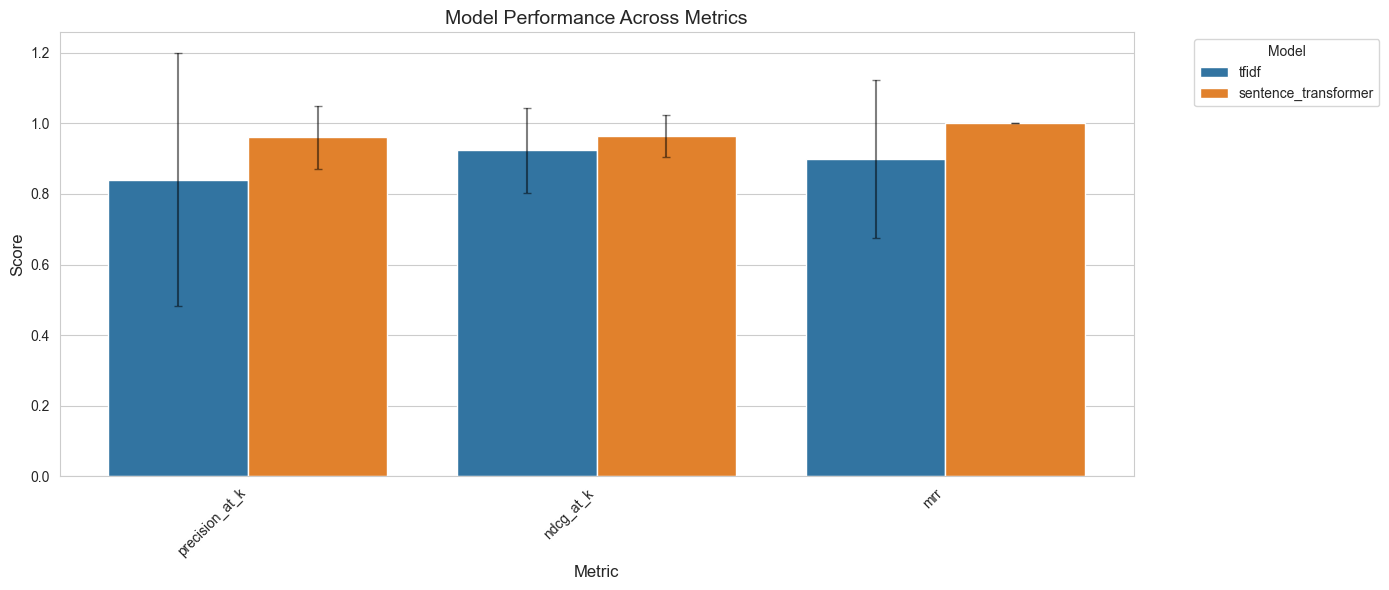

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

def plot_metrics_comparison(results_dict, metrics_to_plot=None):
    """Create grouped bar chart for metric comparison"""
    
    # Prepare data
    data = []
    for model_name, df in results_dict.items():
        for metric in (metrics_to_plot or df.columns):
            data.append({
                'Model': model_name,
                'Metric': metric,
                'Score': df[metric].mean(),
                'Std': df[metric].std()
            })
    
    plot_df = pd.DataFrame(data)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Bar plot with error bars
    sns.barplot(data=plot_df, x='Metric', y='Score', hue='Model', ax=ax)
    
    # Add error bars manually
    x_positions = np.arange(len(plot_df['Metric'].unique()))
    width = 0.8 / len(results_dict)
    
    for i, model in enumerate(results_dict.keys()):
        model_data = plot_df[plot_df['Model'] == model]
        offset = (i - len(results_dict)/2 + 0.5) * width
        ax.errorbar(x_positions + offset, 
                   model_data['Score'], 
                   yerr=model_data['Std'],
                   fmt='none', 
                   color='black', 
                   capsize=3, 
                   alpha=0.5)
    
    plt.title('Model Performance Across Metrics', fontsize=14)
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_metrics_comparison(results, metrics_to_plot=['precision_at_k', 'ndcg_at_k', 'mrr'])

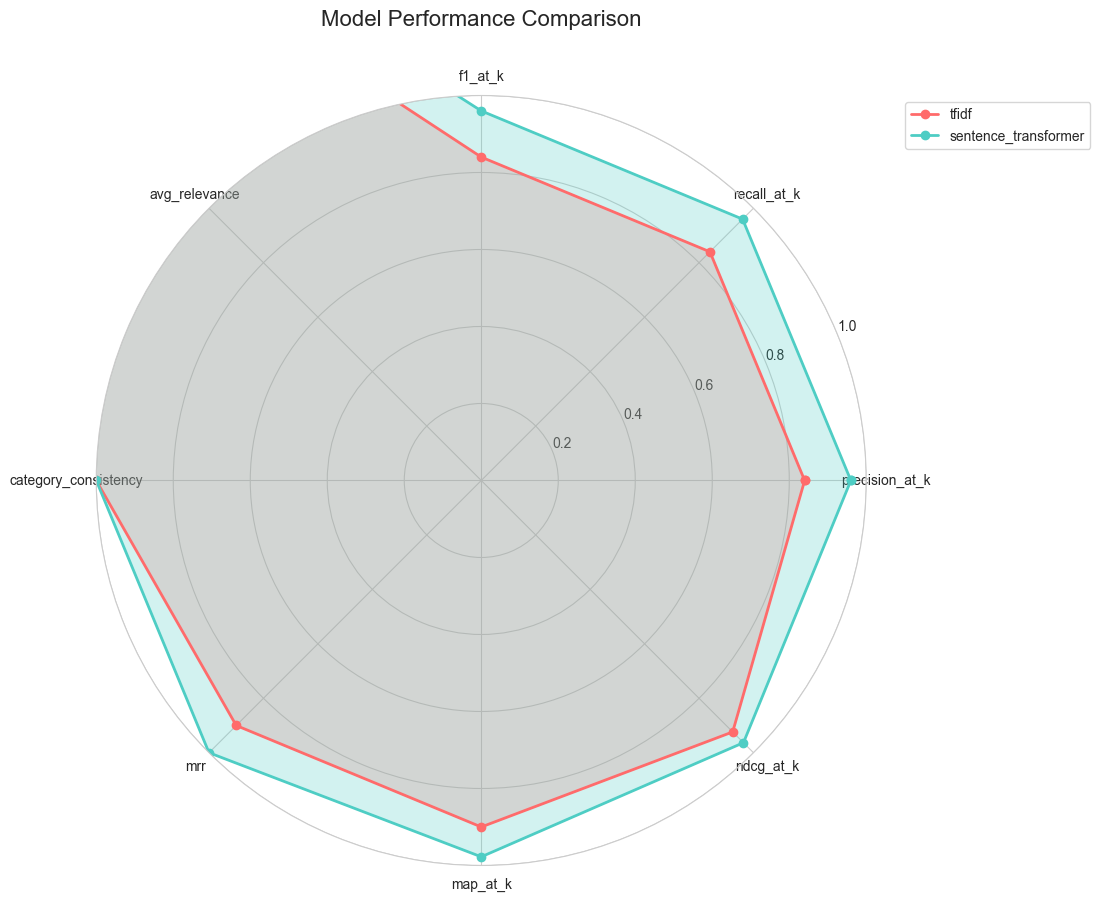

In [53]:
from math import pi

def plot_radar_chart(results_dict, save_path=None):
    """Create radar chart comparing models across all metrics"""
    
    # Prepare data
    models = list(results_dict.keys())
    metrics = list(results_dict[models[0]].columns)
    
    # Number of variables
    num_vars = len(metrics)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Setup plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot for each model
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for idx, model in enumerate(models):
        values = [results_dict[model][metric].mean() for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, 
                label=model, color=colors[idx % len(colors)])
        ax.fill(angles, values, alpha=0.25, color=colors[idx % len(colors)])
    
    # Fix axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, size=10)
    ax.set_ylim(0, 1)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title('Model Performance Comparison', size=16, y=1.08)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_radar_chart(results)

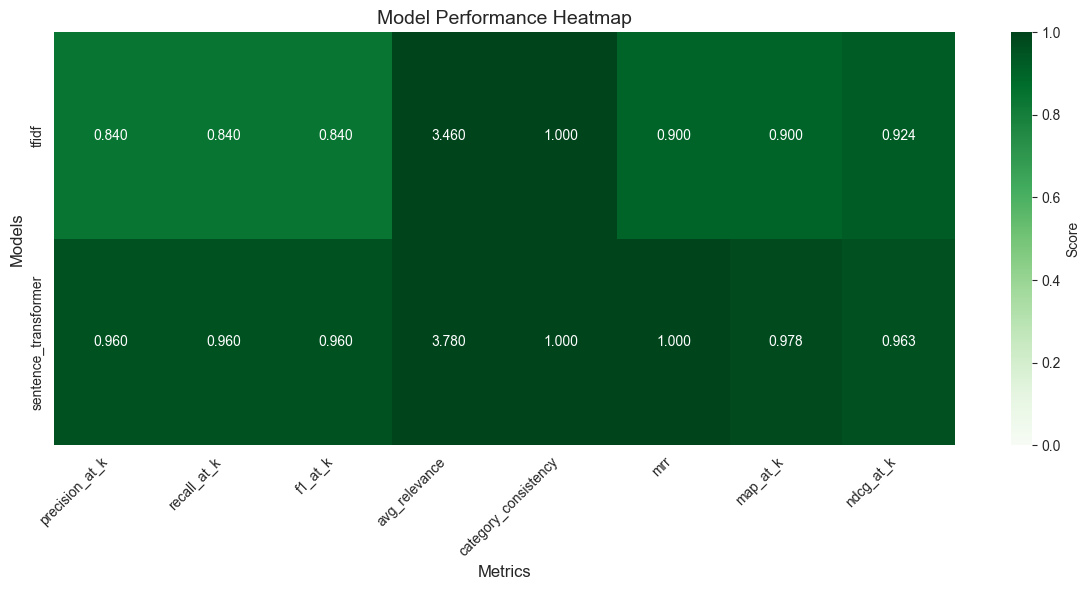

In [43]:
def plot_performance_heatmap(results_dict):
    """Create heatmap of model performance"""
    
    # Create matrix of mean scores
    models = list(results_dict.keys())
    metrics = list(results_dict[models[0]].columns)
    
    matrix = np.zeros((len(models), len(metrics)))
    for i, model in enumerate(models):
        for j, metric in enumerate(metrics):
            matrix[i, j] = results_dict[model][metric].mean()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.heatmap(matrix, 
                annot=True, 
                fmt='.3f',
                xticklabels=metrics,
                yticklabels=models,
                cmap='Greens',
                vmin=0, 
                vmax=1,
                cbar_kws={'label': 'Score'})
    
    plt.title('Model Performance Heatmap', fontsize=14)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Models', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_performance_heatmap(results)